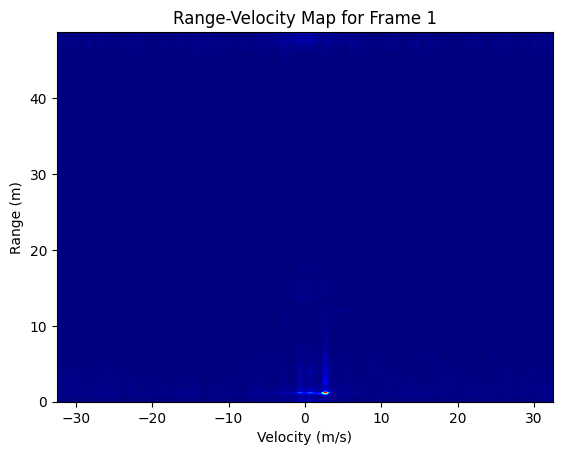

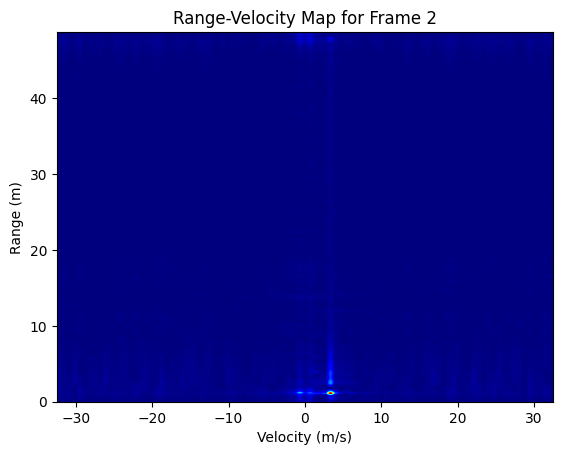

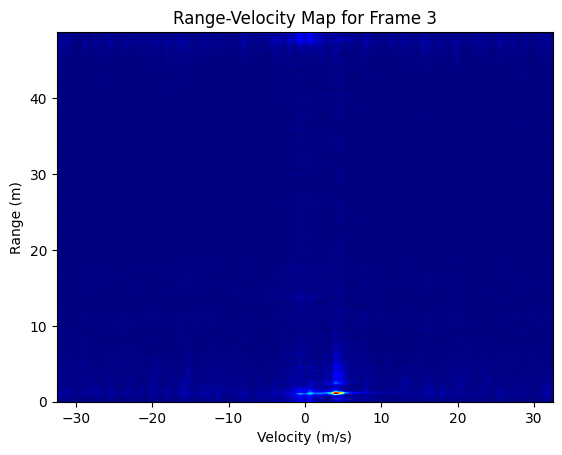

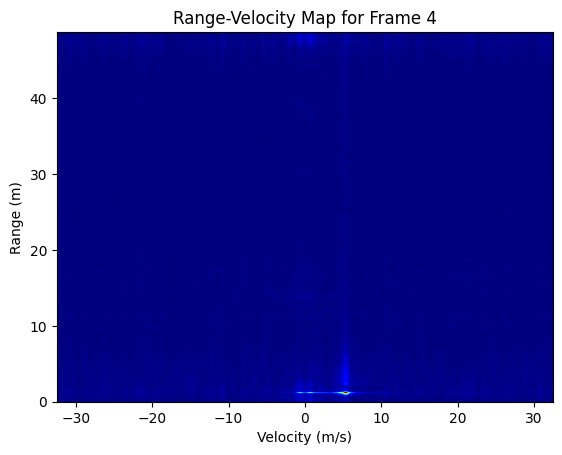

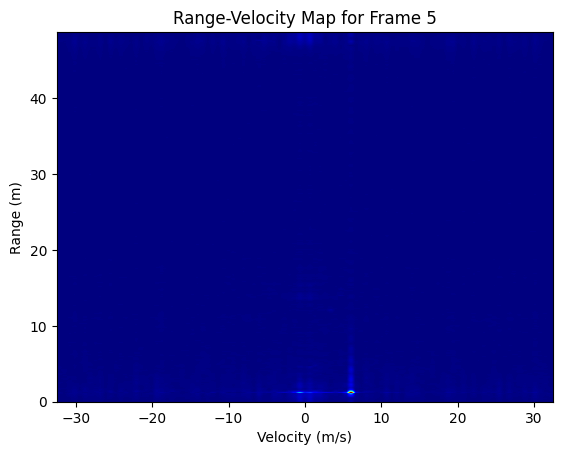

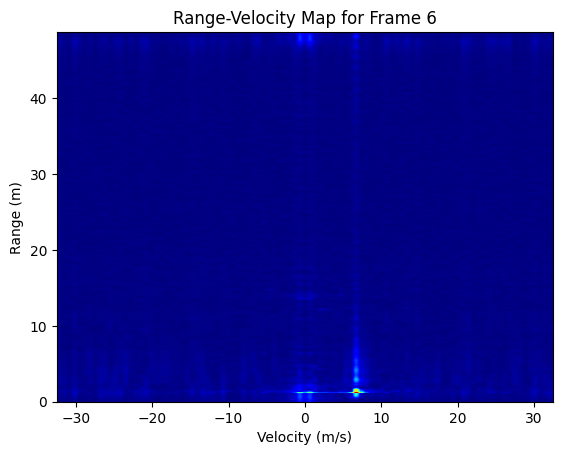

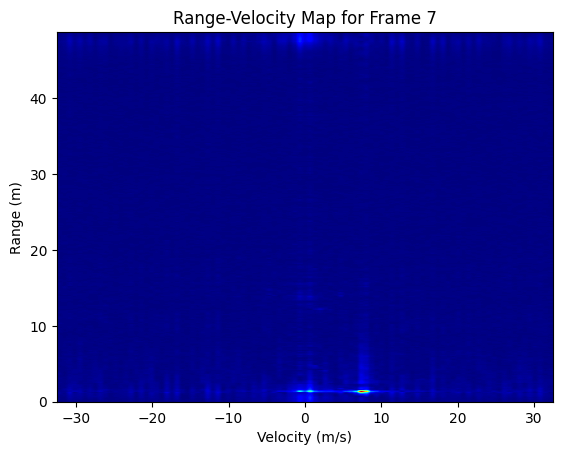

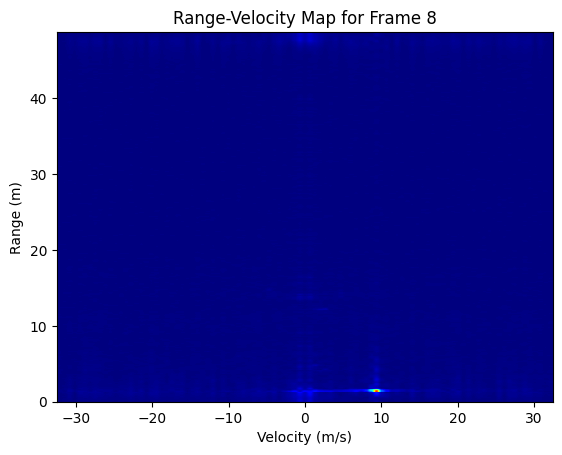

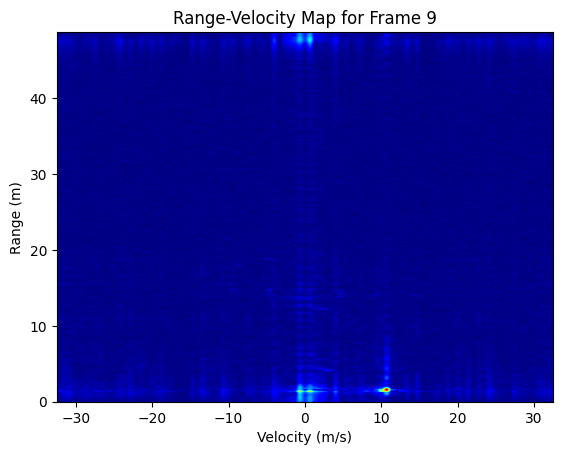

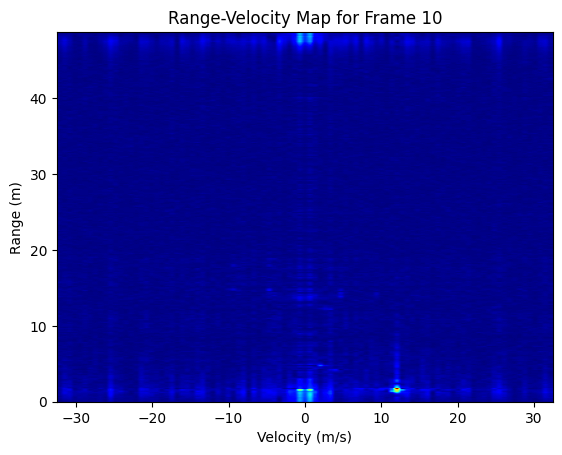

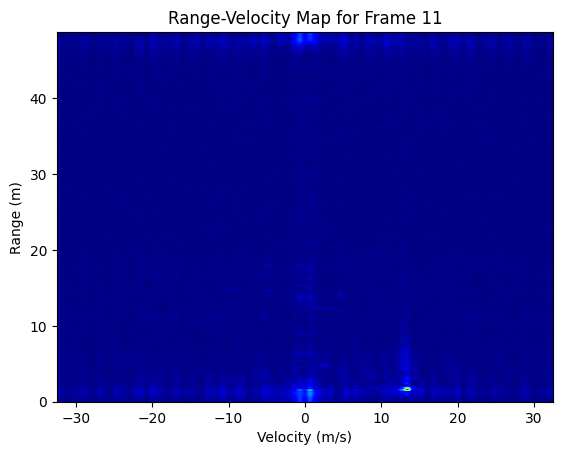

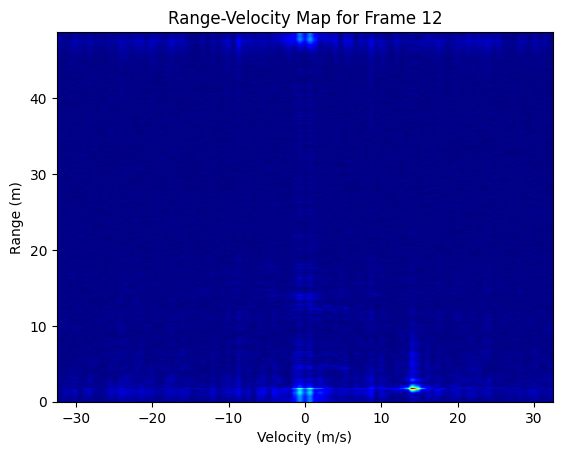

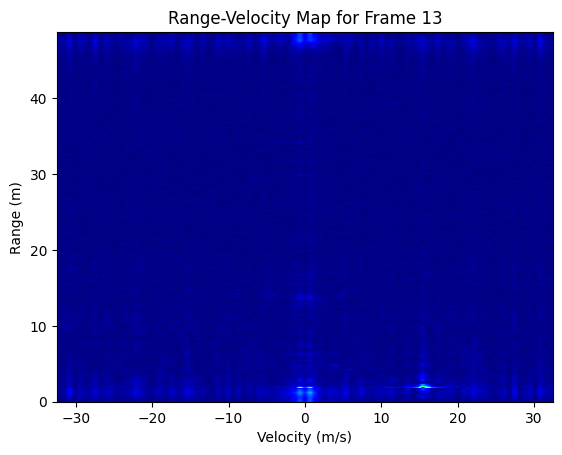

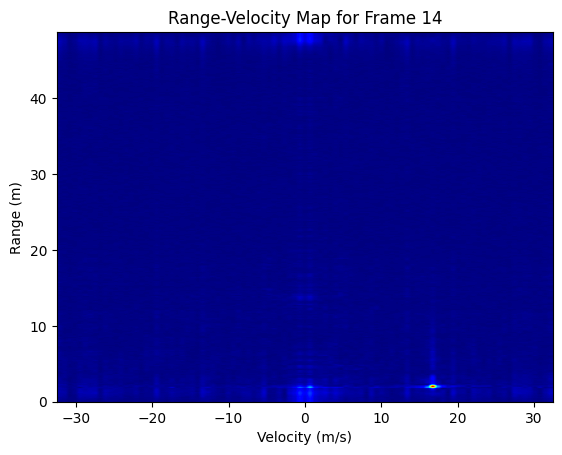

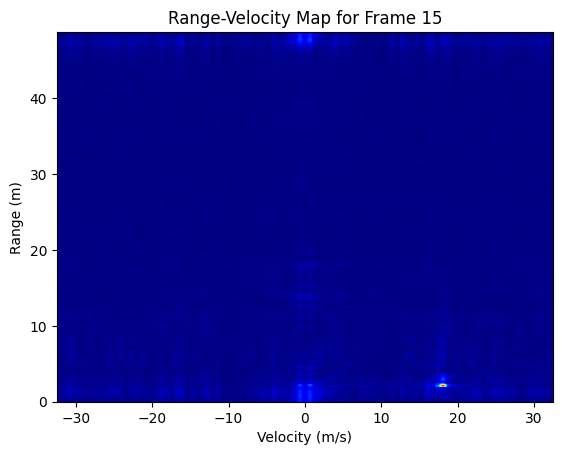

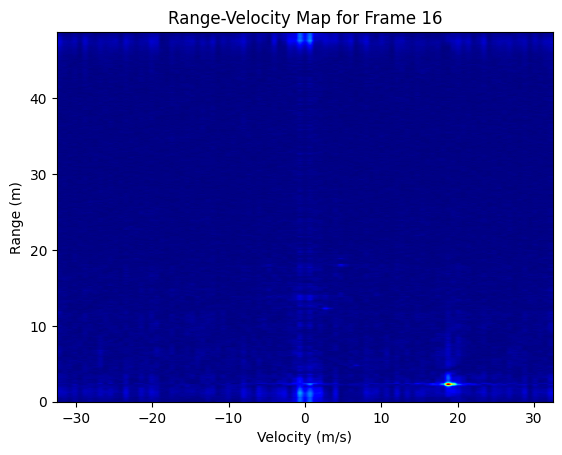

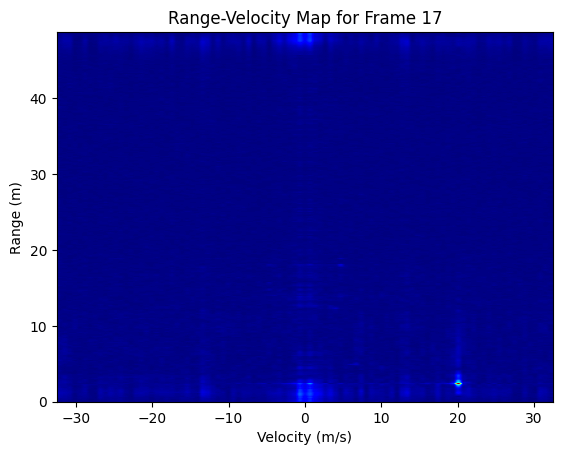

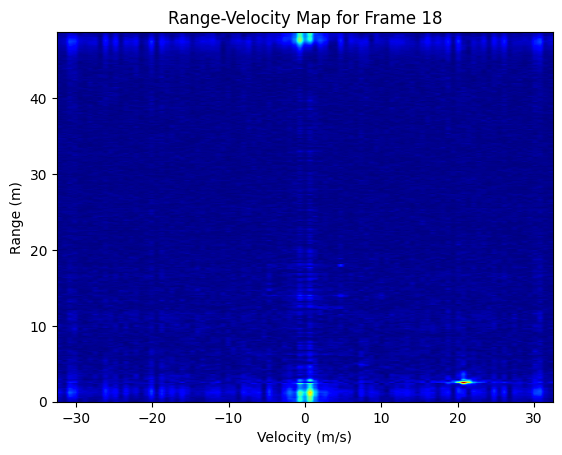

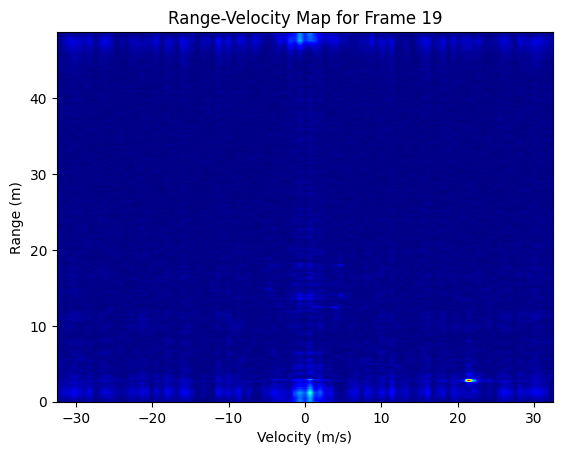

In [17]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define file path and parameters
fileFullPath = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\phantom_forward_2\slave3_0000_data.bin';
frameIdx = 50# Index of the frame to read
numSamplePerChirp = 256  # Number of samples per chirp
numChirpPerLoop = 12  # Number of chirps per loop
numLoops = 128 # Number of loops per frame
numRXPerDevice = 4  # Number of receiving channels per device
numDevices = 4  # Number of devices in the cascade (if needed)
# Create the filter for zero Doppler clutter removal
cutoff_freq = 10  # Set cutoff frequency for the high-pass filter (Hz)
sampling_freq = 1000  # Sampling frequency (example value, should match your data)
def butter_highpass(cutoff, fs, order=6):
    """Design a Butterworth high-pass filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
b, a = butter_highpass(cutoff_freq, sampling_freq)
# Function to read binary radar data
def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
    Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
    with open(fileFullPath, 'rb') as fp:
        # Move to the desired frame in the file
        fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
        adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

    # Convert the 16-bit data to signed integers
    neg = (adcData1 >> 15) == 1  # Check the sign bit
    adcData1 = adcData1.astype(np.int32)
    adcData1[neg] -= 2**16

    # Combine the I and Q channels into complex values
    adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

    # Reshape and permute the data
    adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
    adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
    return adcData1Complex


for frameIdx in range(1,20):

    adcDataComplex = readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)
    average_array=[]
    # Select antenna index and extract chirp ADC matrix
    chirp_ADC_matrix = adcDataComplex[:, :, 3, :]
    specific_transmitter_data = chirp_ADC_matrix[:, :, 0].T
    if filter and b is not None and a is not None:
        specific_transmitter_data = filtfilt(b,a,  specific_transmitter_data , axis=0)
    chirps_matrix = specific_transmitter_data.T
    fc = 77e9
    c = 3e8
    sweepBandwidth = 0.89e9
    chirpDuration = 30e-6

    Nfft_range = 290
    Nfft_doppler = 97

    range_fft = np.fft.fft(chirps_matrix, Nfft_range, axis=0)
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, Nfft_doppler, axis=1), axes=1)

    average_array.append(doppler_fft)

    range_res = c / (2 * sweepBandwidth)
    max_range = range_res * (Nfft_range - 1)
    range_axis = np.linspace(0, max_range, Nfft_range)

    velocity_res = (c / fc) / (2 * numLoops * chirpDuration * 12)
    max_velocity = (c / fc) / (chirpDuration * 4)
    velocity_axis = np.linspace(-max_velocity, max_velocity, Nfft_doppler)

    
    # # Plot the Range-Velocity map (absolute value of FFT)
    plt.figure()
    plt.imshow((np.abs(doppler_fft)), aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], origin='lower',cmap='jet')
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Range (m)')
    plt.title(f'Range-Velocity Map for Frame {frameIdx}')
   
    